<a href="https://colab.research.google.com/github/Koks-creator/SpeechToText/blob/main/SpeechToTextModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip freeze | grep tensorflow

tensorflow==2.17.1
tensorflow-datasets==4.9.7
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-metadata==1.13.1
tensorflow-probability==0.24.0


In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.4 MB/s eta 0:00:00


In [ ]:
from typing import Tuple, List
import pickle
import csv
from google.colab import drive
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.types.experimental import TensorLike
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # special constant that automatically adjusts the number of concurrent threads or processes to process data in the data pipeline
TRAIN_SIZE = .8
VAL_SIZE = .1
TEST_SIZE = .1
# The window length in samples.
FRAME_LENGTH = 256
# The number of samples to step.
FRAME_STEP = 160
# The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
FFT_LENGTH = 384
DATA_URL = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
CHECKPOINT_PATH = "/content/drive/MyDrive/speech_recognition_checkpoints2/checkpoint_{epoch:02d}"
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 10
RNN_UNITS = 512
MODEL_PATH = "speech_model2.h5"
CHAR2NUM_PATH = "char_to_num.pkl"
NUM2CHAR_PATH = "num_to_char.pkl"
LOAD_CHECKPOINT = True

# Load dataset

In [ ]:
drive.mount('/content/drive')
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CHECKPOINT_DIR

'/content/drive/MyDrive/speech_recognition_checkpoints2'

In [ ]:
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [ ]:
data_path = keras.utils.get_file("LJSpeech-1.1", DATA_URL, untar=True)

2748572632/2748572632 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [ ]:
!ls {data_path}/wavs/

LJ001-0001.wav	LJ008-0217.wav	LJ015-0268.wav	LJ023-0099.wav	LJ032-0259.wav	LJ042-0045.wav
LJ001-0002.wav	LJ008-0218.wav	LJ015-0269.wav	LJ023-0100.wav	LJ032-0260.wav	LJ042-0046.wav
LJ001-0003.wav	LJ008-0219.wav	LJ015-0270.wav	LJ023-0101.wav	LJ032-0261.wav	LJ042-0047.wav
LJ001-0004.wav	LJ008-0220.wav	LJ015-0271.wav	LJ023-0102.wav	LJ032-0262.wav	LJ042-0048.wav
LJ001-0005.wav	LJ008-0221.wav	LJ015-0272.wav	LJ023-0103.wav	LJ032-0263.wav	LJ042-0049.wav
LJ001-0006.wav	LJ008-0222.wav	LJ015-0273.wav	LJ023-0104.wav	LJ032-0264.wav	LJ042-0050.wav
LJ001-0007.wav	LJ008-0223.wav	LJ015-0274.wav	LJ023-0105.wav	LJ032-0265.wav	LJ042-0051.wav
LJ001-0008.wav	LJ008-0224.wav	LJ015-0275.wav	LJ023-0106.wav	LJ032-0266.wav	LJ042-0052.wav
LJ001-0009.wav	LJ008-0225.wav	LJ015-0276.wav	LJ023-0107.wav	LJ032-0267.wav	LJ042-0053.wav
LJ001-0010.wav	LJ008-0226.wav	LJ015-0277.wav	LJ023-0108.wav	LJ032-0268.wav	LJ042-0054.wav
LJ001-0011.wav	LJ008-0227.wav	LJ015-0278.wav	LJ023-0109.wav	LJ032-0269.wav	LJ042-0055.wav
LJ001-0012

In [ ]:
wavs_path = f"{data_path}/wavs/"
metadata_path = f"{data_path}/metadata.csv"

In [ ]:
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [ ]:
metadata_df.tail()

,0,1,2
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [ ]:
metadata_df.head()

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [ ]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head()

,file_name,normalized_transcription
0,LJ026-0157,"This process is, however, obscured during the ..."
1,LJ028-0321,Verily he by whom I have been so mutilated sha...
2,LJ008-0194,Some persons were kept for more than five hour...
3,LJ049-0207,that it was not within the Commission's respon...
4,LJ023-0064,Having in mind that in succeeding generations ...


# Create train, val, test datasets and preprocess data

In [ ]:
num_samples = len(metadata_df)
train_range = slice(0, int(TRAIN_SIZE * num_samples))
val_range = slice(int(train_range.stop), int(train_range.stop + (VAL_SIZE * num_samples)))
test_range = slice(val_range.stop, int(val_range.stop + (VAL_SIZE * num_samples)))

In [ ]:
df_train = metadata_df[train_range]
df_val = metadata_df[val_range]
df_test = metadata_df[test_range]

print(f"{len(df_train)=}")
print(f"{len(df_val)=}")
print(f"{len(df_test)=}")

len(df_train)=10480
len(df_val)=1310
len(df_test)=1310


In [ ]:
df_test.head(20)

,file_name,normalized_transcription
11790,LJ022-0056,Our social security legislation is an attempt ...
11791,LJ016-0408,During the singing of these hymns Wainwright f...
11792,LJ007-0137,"More attention to ventilation, which was altog..."
11793,LJ030-0208,"Hill heard a noise, which seemed to be a firec..."
11794,LJ045-0089,Marina Oswald also ridiculed her husband's pol...
11795,LJ019-0335,The books and journals he was to keep were min...
11796,LJ018-0152,With her assistance on a certain day a couple ...
11797,LJ016-0209,Some wags in Scotland seized Calcraft and kept...
11798,LJ014-0231,"Emmanuel Barthelemy again,"
11799,LJ014-0062,He had failed in this as well as in the busine...


In [ ]:
# from google.colab import files

# files.download(f'{data_path}/wavs/LJ014-0062.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Integers to characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '](size =31)


In [ ]:
num_to_char

<StringLookup name=string_lookup_1, built=False>

In [ ]:
char_to_num

<StringLookup name=string_lookup, built=False>

In [ ]:
def encode_single_sample(wav_file: str, label: str, frame_length: int = FRAME_LENGTH,
                         frame_step: int = FRAME_STEP,
                         fft_length: int = FFT_LENGTH
                         ) -> Tuple[EagerTensor, EagerTensor]:
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)

    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, .5) # applies a square root, which can make differences in the magnitude values less extreme.
                                               # This is done for normalization, so that very high values don't dominate the spectrogram.

    # Normalize the spectrogram
    # Here, each column of the spectrogram is standardized by subtracting its mean and dividing by its standard deviation.
    # This ensures that all values have a mean close to 0 and a standard deviation close to 1,
    # making it easier for neural networks to process without bias toward high-magnitude frequency components.
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return spectrogram, label

In [ ]:
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(BATCH_SIZE)  # forces all data rows to have the same shape
    .prefetch(buffer_size=AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

# Define the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_test["file_name"]), list(df_test["normalized_transcription"]))
)
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
for x, y in train_dataset.take(1):
  for i in x:
    print(i.shape)

(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)
(1374, 193)


# Show data

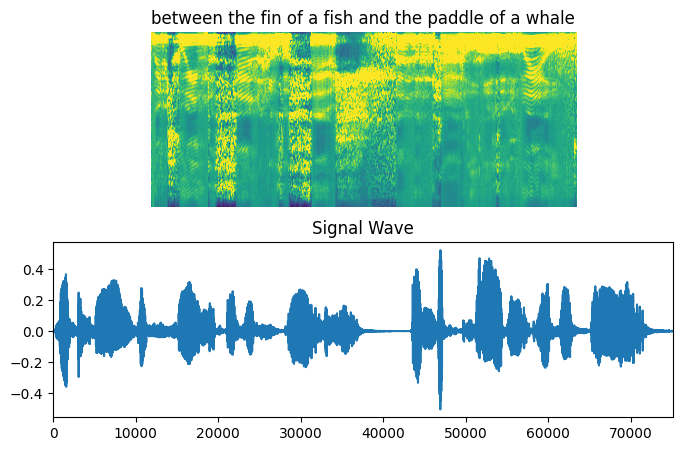

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

# Build model, add loging, checkpoints

##  CTC loss
CTC loss, or **Connectionist Temporal Classification Loss**, is a loss function used primarily in sequence recognition tasks where the output length is not specified. It is particularly useful in speech recognition, image-to-text transcription (OCR) and other sequence processing model

 - **How does CTC Loss work?** <br>
Independence of input and output length: In many cases, the length of the input sequence (e.g., the number of frames in an audio recording) differs from the length of the expected output sequence (e.g., the number of characters in a transcription). CTC is designed to handle this problem.

- **Inserting a “blank” symbol**: <br>
 CTC uses an additional blank symbol (meaning “no character”) to help deal with the situation when the model does not predict a new character in each input frame. Blank symbols allow the model to differentiate between adjacent characters and ignore redundant predictions.

- **Different matches (alignment)**: <br>
CTC calculates the probability of different possible matches between the input sequence and the output sequence. For example, for an input audio signal that corresponds to the output “HELLO,” the model can generate multiple combinations (e.g., “H_E_LL_O_” where “_” is a blank) that will be interpreted as correct transcriptions.

In sequential tasks like speech recognition, the length of the input (e.g., the number of audio frames) is variable, as is the length of the output (e.g., the number of words or characters in a transcription). CTCLoss is designed specifically to deal with this variability in length, allowing for different input to output matches and inserting blank symbols in the appropriate places

Read some more boyo here maybe:
 - https://voidful.medium.comunderstanding-ctc-loss-for-speech-recognition-a16a3ef4da92

 - https://medium.com/@akp83540/connectionist-temporal-classification-ctc-722bbb767e62

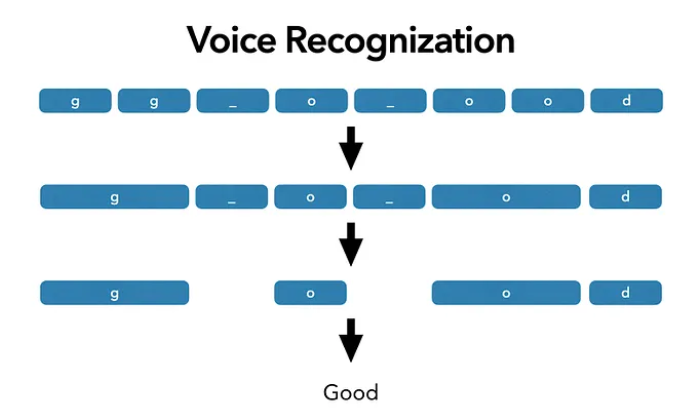

In [ ]:
def CTCLoss(y_true: TensorLike, y_pred: TensorLike) -> tf.Tensor:
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def ctc_accuracy(y_true: TensorLike, y_pred: TensorLike) -> tf.Tensor:
    # Get batch size and max length for input lengths
    batch_size = tf.shape(y_pred)[0]
    max_length = tf.shape(y_pred)[1]
    input_lengths = tf.fill([batch_size], max_length)

    # Convert y_true to SparseTensor
    y_true = tf.cast(y_true, tf.int64)
    indices = tf.where(tf.not_equal(y_true, 0))
    values = tf.gather_nd(y_true, indices)
    dense_shape = tf.cast(tf.shape(y_true), tf.int64)
    y_true = tf.SparseTensor(indices, values, dense_shape)

    # Decode the predictions
    decoded, _ = tf.nn.ctc_greedy_decoder(
        tf.transpose(y_pred, [1, 0, 2]),
        input_lengths,
        merge_repeated=True
    )

    # Cast decoded values to int64
    decoded_sparse = tf.cast(decoded[0], tf.int64)

    # Calculate accuracy using edit_distance
    accuracy = 1 - tf.reduce_mean(
        tf.edit_distance(decoded_sparse, y_true, normalize=True)
    )

    return accuracy

# DeepSpeech-Inspired Speech Recognition Model

This model is inspired by DeepSpeech2, designed for speech-to-text applications. It processes audio input (spectrograms) through convolutional and recurrent layers to generate textual predictions.

## Model Architecture

### 1. Model Input
- **Shape**: The model accepts a 2D spectrogram as input, represented as `(time_steps, frequency_bins)`, where each time step corresponds to a time frame, and each frequency bin represents spectral information at that frame.
- **Layer**: `input_spectrogram` serves as the input layer, handling spectrograms with variable time steps (`None` in the time dimension).

### 2. Expand Dimensions for 2D Convolutional Layers
- **Reshape Layer**: `layers.Reshape` expands the input to `(time_steps, frequency_bins, 1)` to allow 2D convolutional processing.
  
### 3. Convolutional Layers
The model applies two 2D convolutional layers to extract features from the spectrogram.

- **Conv Layer 1**:
  - Filters: 32
  - Kernel Size: `[11, 41]`
  - Strides: `[2, 2]` (reduces the input size in both time and frequency dimensions)
  - Activation: `ReLU`
  - Normalization: Batch normalization applied after convolution.

- **Conv Layer 2**:
  - Filters: 32
  - Kernel Size: `[11, 21]`
  - Strides: `[1, 2]`
  - Activation: `ReLU`
  - Normalization: Batch normalization applied after convolution.

After the convolutional layers, the output is reshaped to a sequence format to feed into the recurrent layers.
Convolution layers extract features which helps with ignoring irrelevant patterns or noise in the spectrogram, so model can focus on speech.

### 4. Bidirectional GRU Layers
The model uses stacked bidirectional GRU (Gated Recurrent Unit) layers to capture temporal dependencies in the audio sequence.

- **GRU Layers**:
  - Number of Layers: `rnn_layers` (specified as a hyperparameter)
  - Units per Layer: `rnn_units`
  - Direction: Bidirectional (processes the sequence forwards and backwards)
  - Dropout: Applied between GRU layers to prevent overfitting

- **Sigmoid Activation in GRU**:
  Each GRU layer uses a **sigmoid activation** function within its *update* and *reset gates*:
  - **Update Gate**: Controls the flow of information from the previous time step.
  - **Reset Gate**: Controls how much past information to "forget."
  - The sigmoid activation constrains the gate outputs to a range between 0 and 1, enabling fine control over memory retention and flow through the sequence. This makes GRUs effective at handling longer-term dependencies in sequences.

### 5. Dense Layer
- A fully connected layer (`dense_1`) is used to further process the output of the recurrent layers.
  - Units: `rnn_units * 2`
  - Activation: `ReLU`
  - Dropout: Applied after this layer for additional regularization.

### 6. Output Layer
- The final output layer is a fully connected layer with `output_dim + 1` units, where each unit represents a character or a blank symbol (for CTC loss).
- **Activation**: `softmax`, which converts the output to a probability distribution over possible characters.

In [ ]:
def build_model(input_dim: int, output_dim: int, rnn_layers: int = 5, rnn_units: int = 128, learning_rate: float = 1e-4) -> keras.Model:
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input") # (None, None, 193), batch, time, frequency bins
    # Speech inputs vary in length depending on the length of the audio clip.
    # By setting the time dimension to None, the model can accept inputs of varying lengths during both training and inference.

    # Expand the dimension to use 2D CNN
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1"
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2"
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshape to sequence
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    for i in range(1, rnn_layers+1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}"
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers: # apply a Dropout layer only between the RNN layers, and not after the last RNN layer,
                           # because droput after directly after last RNN layer cus it breaks sequential information
          x = layers.Dropout(rate=.5)(x)

    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)  # after activation it's fine
    x = layers.Dropout(rate=.5)(x)

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    model = keras.Model(input_spectrogram, output, name="DeepSpeech")

    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=CTCLoss, metrics=[ctc_accuracy])

    return model

In [ ]:
def load_latest_checkpoint(checkpoint_dir: str = CHECKPOINT_DIR) -> bool:
    # Get all checkpoint files and sort them
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_')])

    if checkpoints:
        latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
        print(f"Loading checkpoint: {latest_checkpoint}")
        model.load_weights(latest_checkpoint)
        return True
    return False

In [ ]:
os.listdir(CHECKPOINT_DIR)

['speech_model2.keras', 'checkpoint_01.keras', 'training_log.csv']

Custom csv logger to monitor ctc accuracy as well

In [ ]:
class CustomCSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_path):
        super().__init__()
        self.log_path = log_path
        self.epoch = 0

    def on_train_begin(self, logs = None) -> None:
        if os.path.exists(self.log_path):
            self.mode = "a"
            self.header = False
        else:
            self.mode = "w"
            self.header = True

        self.csvfile = open(self.log_path, self.mode, newline='')
        self.writer = csv.writer(self.csvfile)

        if self.header:
            self.writer.writerow(["epoch", "loss", "val_loss", "ctc_accuracy", "val_ctc_accuracy"])
            self.csvfile.flush()
        self.csvfile.close()

    def on_epoch_end(self, epoch: int, logs = None) -> None:
        self.csvfile = open(self.log_path, "a", newline='')
        self.writer = csv.writer(self.csvfile)
        logs = logs or {}

        row = [
            self.epoch,
            logs.get("loss", "N/A"),
            logs.get("val_loss", "N/A"),
            logs.get("ctc_accuracy", "N/A"),
            logs.get("val_ctc_accuracy", "N/A")
        ]
        self.writer.writerow(row)
        self.csvfile.flush()
        self.epoch += 1
        self.csvfile.close()

    def on_train_end(self, logs=None) -> None:
        self.csvfile.close()

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH + ".keras",
        save_weights_only=False,
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    ),
     CustomCSVLogger(fr"{CHECKPOINT_DIR}/training_log.csv")
]

In [ ]:
model = build_model(
    input_dim=FFT_LENGTH // 2 + 1,  # take only unique frequency bins
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=RNN_UNITS,
    learning_rate=LEARNING_RATE
)
model.summary()

Model: "DeepSpeech"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, 193)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dim (Reshape)                 │ (None, None, 193, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, None, 97, 32)        │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_bn (BatchNormalization)       │ (None, None, 97, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_relu (ReLU)                   │ (None, None, 97, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, None, 49, 32)        │         236,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_bn (BatchNormalization)       │ (None, None, 49, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_relu (ReLU)                   │ (None, None, 49, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, None, 1568)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 1024)          │       6,395,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 1024)          │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1_relu (ReLU)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
if LOAD_CHECKPOINT:
    load_latest_checkpoint()

Loading checkpoint: /content/drive/MyDrive/speech_recognition_checkpoints2/checkpoint_01.keras


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Train model

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - ctc_accuracy: 0.9064 - loss: 33.9432
Epoch 1: val_loss improved from inf to 27.21611, saving model to /content/drive/MyDrive/speech_recognition_checkpoints2/checkpoint_01.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 1489s 4s/step - ctc_accuracy: 0.9064 - loss: 33.9452 - val_ctc_accuracy: 0.9395 - val_loss: 27.2161
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - ctc_accuracy: 0.9217 - loss: 30.8161
Epoch 2: val_loss did not improve from 27.21611
328/328 ━━━━━━━━━━━━━━━━━━━━ 870s 3s/step - ctc_accuracy: 0.9217 - loss: 30.8188 - val_ctc_accuracy: 0.9386 - val_loss: 27.5207
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - ctc_accuracy: 0.9136 - loss: 29.0629
Epoch 3: val_loss did not improve from 27.21611
328/328 ━━━━━━━━━━━━━━━━━━━━ 870s 3s/step - ctc_accuracy: 0.9136 - loss: 29.0658 - val_ctc_accuracy: 0.9372 - val_loss: 28.8184
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - ctc_accuracy: 0.9262 - loss: 27.6763
Epoch 4: val_loss d

KeyboardInterrupt: 

In [ ]:
train_hist_df = pd.read_csv(fr"{CHECKPOINT_DIR}/training_log.csv")
train_hist_df.columns

Index(['epoch', 'loss', 'val_loss', 'ctc_accuracy', 'val_ctc_accuracy'], dtype='object')

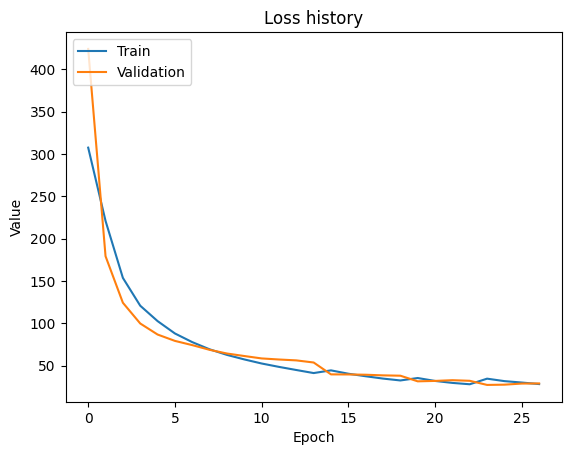

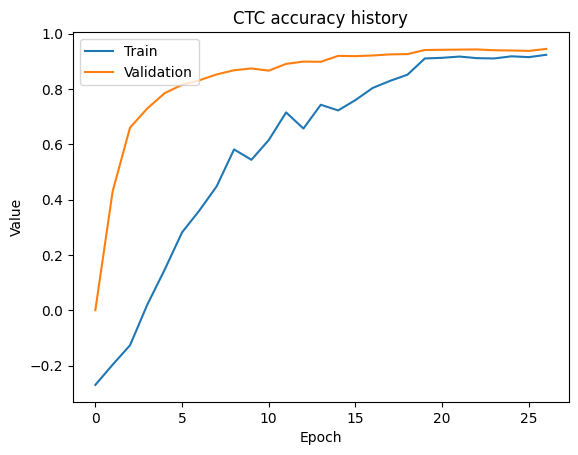

In [ ]:
plt.plot(train_hist_df["loss"])
plt.plot(train_hist_df["val_loss"])
plt.title("Loss history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_hist_df["ctc_accuracy"])
plt.plot(train_hist_df["val_ctc_accuracy"])
plt.title("CTC accuracy history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Test model

 This function applies the Connectionist Temporal Classification (CTC) decoding algorithm, which translates the output probability sequences into sequences of characters by removing repeated predictions and blank tokens.

In [ ]:
def decode_batch_predictions(pred) -> List[str]:
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for result in results:
        # concatenates the characters into a single string in utf-8
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [ ]:
predictions = []
targets = []
for batch in test_dataset.take(1):
    X, y = batch
    # print(len(y[0]) - np.count_nonzero(y[0]))
    # # print(y[0].count(0))
    # print(len(tf.strings.reduce_join(num_to_char(y[0])).numpy().decode("utf-8")))
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in range(len(predictions)):
    print(f"Target        : {targets[i]}")
    print(f"Prediction    : {predictions[i]}")
    print("-" * 100)


# Save model

In [ ]:
model.save(MODEL_PATH)

with open(CHAR2NUM_PATH, "wb") as c2n_file:
    pickle.dump(char_to_num, c2n_file)

with open(NUM2CHAR_PATH, "wb") as n2c_file:
    pickle.dump(num_to_char, n2c_file)

# Load model and re-test

In [ ]:
model_loaded = keras.models.load_model(MODEL_PATH,
                              custom_objects={'CTCLoss': CTCLoss,
                                            'ctc_accuracy': ctc_accuracy})

In [ ]:
model_loaded.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=CTCLoss,
    metrics=[ctc_accuracy]
)

In [ ]:
predictions = []
targets = []
for batch in test_dataset.take(1):
    X, y = batch
    # print(len(y[0]) - np.count_nonzero(y[0]))
    # # print(y[0].count(0))
    # print(len(tf.strings.reduce_join(num_to_char(y[0])).numpy().decode("utf-8")))
    batch_predictions = model_loaded.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in range(len(predictions)):
    print(f"Target        : {targets[i]}")
    print(f"Prediction    : {predictions[i]}")
    print("-" * 100)
